#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [1]:
%matplotlib notebook
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt
from src.analyse import compute_normalized_entropy

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

import datetime
#import seaborn

Populating the interactive namespace from numpy and matplotlib


## Read the file

In [2]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [3]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")
df["creationDate"] = pd.to_datetime(df["creationDate"])

## Visualization of consistent fingerprints

In [4]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 48714 elements in df_consistent


In [148]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [149]:
# Visualization of the first 5 lines
df_consistent.head(5)

counter                                    id        creationDate  \
15       17  0f4f77e3-80da-4b4a-b9c0-f5e8c4239380 2015-07-27 11:00:00   
17       19  74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3 2015-07-27 12:00:00   
18       20  df46c5fb-9889-4ff4-9f51-e5af591f3460 2015-07-27 12:00:00   
19       21  dc031028-a4ea-4ce8-a362-17b07a4f4d65 2015-07-27 12:00:00   
20       22  d51d09c6-2596-4958-bfe7-0352af2aaccf 2015-07-27 12:00:00   

                endDate                               addressHttp  \
15                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
17                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
18                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
19  2015-07-28 11:00:00  90f2974eff1d1b3f05d01f413cf0241fae23352e   
20  2015-07-29 06:00:00  2515ee56512877237d467911f5c55be53eea3550   

                                        userAgentHttp  \
15  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
17  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
18  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
19  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...   
20  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   

                                           acceptHttp connectionHttp  \
15  text/html,application/xhtml+xml,application/xm...          close   
17  text/html,application/xhtml+xml,application/xm...          close   
18  text/html,application/xhtml+xml,application/xm...          close   
19  text/html,application/xhtml+xml,application/xm...          close   
20  text/html,application/xhtml+xml,application/xm...          close   

           encodingHttp                         languageHttp    ...      \
15  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
17  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
18  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
19  gzip, deflate, sdch  fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4    ...       
20  gzip, deflate, sdch  fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4    ...       

     platformFlash browserFamily globalBrowserVersion minorBrowserVersion  \
15           Linux        Chrome                  440                   0   
17           Linux        Chrome                  440                   0   
18           Linux        Chrome                  440                   0   
19  Mac OS 10.10.4        Chrome                  440                   0   
20           Linux        Chrome                  430                   0   

   majorBrowserVersion        os                       rendererWebGLJS  \
15                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
17                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
18                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
19                  44  Mac OS X  Intel HD Graphics 5000 OpenGL Engine   
20                  43     Linux                         Not supported   

                          vendorWebGLJS  \
15  Intel Open Source Technology Center   
17  Intel Open Source Technology Center   
18  Intel Open Source Technology Center   
19                           Intel Inc.   
20                        Not supported   

                                            pluginsJS consistent  
15  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
17  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
18  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
19  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
20  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  

[5 rows x 33 columns]

In [150]:
print("Statistics on dataset filtered: only consistent browsers") 
number_distinct_list=[]
for attribute in attributes_to_analyze:
    nb_distinct_values_by_attribute = df_consistent[attribute].value_counts()
    nb_distinct_values_global = nb_distinct_values_by_attribute.count()
    nb_unique_values = len(nb_distinct_values_by_attribute[nb_distinct_values_by_attribute.values == 1])


    number_distinct_list.append({
           "Attribute": attribute,
           "Distinct values": nb_distinct_values_global,
           "Unique values": nb_unique_values
      })   
number_distinct_df=pd.DataFrame(number_distinct_list).sort_values(by="Distinct values", ascending=False).reset_index(drop=True)
number_distinct_df

Statistics on dataset filtered: only consistent browsers


Attribute  Distinct values  Unique values
0            addressHttp            15726          10834
1       fontsFlashHashed             4679           2149
2                     id             4643           2123
3        pluginsJSHashed             4186           1940
4              pluginsJS             4185           1940
5          userAgentHttp             2286            980
6         canvasJSHashed              930            289
7        rendererWebGLJS              489            108
8           resolutionJS              446            218
9           languageHttp              422             89
10       resolutionFlash              257            109
11         platformFlash              222             69
12             orderHttp              107             36
13  globalBrowserVersion               78             21
14   majorBrowserVersion               43              5
15            timezoneJS               33              3
16         languageFlash               27              2
17   minorBrowserVersion               21              3
18         browserFamily               18              5
19            platformJS               17              6
20                    os               14              1
21         vendorWebGLJS               13              0
22          encodingHttp               12              2
23            acceptHttp                7              4
24             sessionJS                2              0
25                 dntJS                2              0
26             cookiesJS                2              0
27               localJS                2              0
28        connectionHttp                1              0

## Descriptive analysis of consistent fingerprints

In [10]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
           "Attribute": attribute,
           "Relative entropy": compute_normalized_entropy(df, attribute)
       })    
    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    print(entropy_df)

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

               Attribute  Relative entropy
0            addressHttp          0.888301
1                     id          0.781561
2              pluginsJS          0.630395
3          userAgentHttp          0.613847
4        pluginsJSHashed          0.610079
5       fontsFlashHashed          0.542996
6         canvasJSHashed          0.487428
7           languageHttp          0.320505
8           resolutionJS          0.289189
9   globalBrowserVersion          0.269478
10       rendererWebGLJS          0.266548
11   majorBrowserVersion          0.264609
12       resolutionFlash          0.232677
13            timezoneJS          0.227500
14         platformFlash          0.222875
15             orderHttp          0.193803
16                    os          0.171668
17         languageFlash          0.164726
18          encodingHttp          0.122460
19         vendorWebGLJS          0.116709
20            platformJS          0.108445
21         browserFamily          0.087173
22         

In [6]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

     effective          %
yes       4268  89.494653
no         501  10.505347



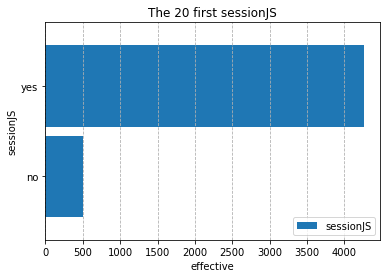

There are 0 unique terms for the attribute 'sessionJS'

The most used terms are: 
yes    4268
no      501
Name: sessionJS, dtype: int64


In [7]:
terms_analysis(df_consistent, 'sessionJS')

The distinct values for the attribute 'languageHttp' are : 
 ['de' 'pt' 'ru' 'en' 'fr' 'cs' 'da' 'it' 'nl' 'sv' 'sl' 'es' 'nb' 'hu'
 'pl' 'sh' 'ja' 'ac' 'uk' 'zh' 'tr' 'az' 'sk' 'fi' 'ko' 'th' 'vi' 'hr'
 'ro' 'an' 'ch' 'ca' 'ar' 'lt' 'el' 'af' 'bg' 'et']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
ac          8   0.161584
sv          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
af          4   0.080792
hr          4   0.080792
lt          3   0.060594
sl          3   0.060594
el          2   0.040396
nb          2   0.040396
sh          2   0.0

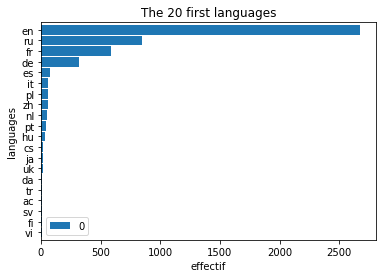

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [10]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [8]:
def analysis_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

                                                    effective          %
Chrome PDF Viewer                                        8912  14.564947
Shockwave Flash                                          8474  13.849121
Widevine Content Decryption Module                       4792   7.831601
Native Client                                            4679   7.646924
Microsoft Office                                         3228   5.275544
Adobe Acrobat                                            2889   4.721514
Google Update                                            2278   3.722952
Silverlight Plug-In                                      1862   3.043080
QuickTime Plug-in                                        1695   2.770151
JavaTM Platform SE                                       1657   2.708047
Java Deployment Toolkit                                  1591   2.600183
Intel                                                    1398   2.284762
VLC Web Plugin                                     

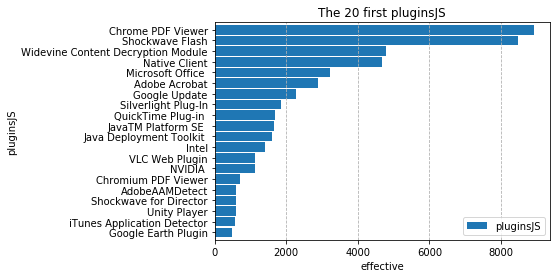

There are 106 unique terms for the attribute 'pluginsJS'

The most used terms are: 
Chrome PDF Viewer                     8912
Shockwave Flash                       8474
Widevine Content Decryption Module    4792
Native Client                         4679
Microsoft Office                      3228
Name: pluginsJS, dtype: int64

There are 460 pluginsJS


In [255]:
analysis_terms_splited(df_consistent, 'pluginsJS', split_plugins)

In [10]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [38]:
analyze_grouped(df_consistent,'localJS', 'sessionJS')

KeyError: 'sessionJS'

In [11]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]

In [23]:
analyze_grouped_splited(df_consistent, 'encodingHttp', 'browserFamily', split_encoding_http)


browserFamily
Firefox    3
dtype: int64
11703118
br
browserFamily
Chrome            1597
Chromium            43
Dragon               3
Epiphany             1
Firefox           1912
IE Mobile            1
Iceweasel            3
Iron                28
Konqueror            1
Opera                8
Other                5
QupZilla             1
Rekonq               1
SeaMonkey            1
Vivaldi             38
Yandex Browser       4
dtype: int64
876300
bzip2
browserFamily
Chrome    1
dtype: int64
11713896
compress
browserFamily
Chrome    1
dtype: int64
11713896
deflate
browserFamily
Chrome                         2274
Chromium                         72
Dragon                            9
Epiphany                          2
Firefox                        2553
IE Mobile                         1
Iceweasel                        32
Iron                             37
Konqueror                         1
Maxthon                           1
Opera                            15
Other           

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

## Inconsistent fingerprint detection

In [139]:
dict_null=[]
for attribute in attributes_to_analyze:
    nb_values_null = len(df_consistent[df_consistent[attribute].isnull()])
    dict_null.append({
        "attribute":attribute,
        "number of values null":nb_values_null
    })
df_dict_null = pd.DataFrame(dict_null)
df_dict_null

attribute  number of values null
0                     id                      0
1            addressHttp                      0
2          userAgentHttp                      7
3             acceptHttp                      0
4         connectionHttp                      0
5           encodingHttp                      2
6           languageHttp                     15
7              orderHttp                      0
8        pluginsJSHashed                      0
9             platformJS                      1
10             cookiesJS                      0
11                 dntJS                      0
12            timezoneJS                      0
13          resolutionJS                      0
14               localJS                      0
15             sessionJS                      0
16        canvasJSHashed                      0
17      fontsFlashHashed                      0
18       resolutionFlash                      0
19         languageFlash                      0
20         platformFlash                      0
21         browserFamily                      0
22  globalBrowserVersion                      0
23   minorBrowserVersion                      0
24   majorBrowserVersion                      0
25                    os                      0
26       rendererWebGLJS                      0
27         vendorWebGLJS                      0
28             pluginsJS                   1905

In [142]:
# Détection of inconsistent values
df_consistent[df_consistent['platformJS'].isnull()]

counter                                    id        creationDate  \
38502    49117  bb2d1703-0c56-49cd-bf02-4af5d1bceb30 2016-06-30 12:00:00   

      endDate                               addressHttp  \
38502    None  5aff60bc3b6c8c04f3c5934e10a9cfff857751a2   

                                           userAgentHttp  \
38502  Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.3...   

                                              acceptHttp connectionHttp  \
38502  text/html,application/xhtml+xml,application/xm...          close   

        encodingHttp    languageHttp    ...     platformFlash browserFamily  \
38502  gzip, deflate  en-GB,en;q=0.5    ...         Windows 7        Chrome   

      globalBrowserVersion minorBrowserVersion majorBrowserVersion  \
38502                  450                   0                  45   

                  os rendererWebGLJS  vendorWebGLJS  \
38502  Windows Vista   Not supported  Not supported   

                                               pluginsJS consistent  
38502  Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For...       True  

[1 rows x 33 columns]

In [119]:
# Id of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['id'] == "d2356d2d-9796-4522-949e-616aa1521059"]

counter                                    id        creationDate  \
71595    93843  d2356d2d-9796-4522-949e-616aa1521059 2016-12-04 01:00:00   

      endDate                               addressHttp userAgentHttp  \
71595    None  8f60d3ad84d108cabb80a4e40a488878396c0448           NaN   

                                              acceptHttp connectionHttp  \
71595  text/html,application/xhtml+xml,application/xm...          close   

            encodingHttp    languageHttp    ...           platformFlash  \
71595  gzip, deflate, br  en-US,en;q=0.5    ...      Flash not detected   

      browserFamily globalBrowserVersion minorBrowserVersion  \
71595         Other               zzzzzz                None   

      majorBrowserVersion     os rendererWebGLJS  vendorWebGLJS pluginsJS  \
71595                None  Other   Not supported  Not supported       NaN   

      consistent  
71595       True  

[1 rows x 33 columns]

In [109]:
df_consistent['browserFamily'].value_counts()

Chrome                         28157
Firefox                        19183
Chromium                         425
Iron                             353
Vivaldi                          220
Iceweasel                        141
Opera                             71
Dragon                            37
Yandex Browser                    21
Other                             11
IE Mobile                          3
Epiphany                           2
Pale Moon (Firefox Variant)        2
Maxthon                            1
Rekonq                             1
QupZilla                           1
SeaMonkey                          1
Konqueror                          1
Name: browserFamily, dtype: int64

In [165]:
df_consistent[df_consistent['encodingHttp'] == "gzip, deflate, , br"]["id"]

82110    b6c38cfd-7fc0-4591-b908-bcd7769ab2b5
Name: id, dtype: object

## Temporal analysis of consistent fingerprints

In [5]:
#id with more 2 fingerprints
number_fingerprints_by_id=df_consistent['id'].value_counts()
df_number_fingerprints_by_id=pd.DataFrame(number_fingerprints_by_id)
user_more_2_fingerprints=[]
for user_id, number in df_number_fingerprints_by_id.iteritems():
    for i in range(0, len(number)):
        if number[i] != 1:
            user_more_2_fingerprints.append({
                "valeur":number[i],
                "index":number.index[i]
            })
            
df_user_more_2_fingerprints=pd.DataFrame(user_more_2_fingerprints)

### Number of plugins in time

In [8]:
print("The following analysis is done from {} to {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))

The following analysis is done from 2015-07-27 11:00:00 to 2017-03-13 01:00:00


In [9]:
evolution=[]
for user_id in df_user_more_2_fingerprints['index']:
    date=df_consistent[df_consistent['id']==user_id]['creationDate']   
    year_month=[]
    for key, line in date.iteritems():
        year_month.append({
            "cle": key,
            "Date":line[:7]
        })

    df_year_month = pd.DataFrame(year_month)
    
    plugins = df_consistent[df_consistent['id']==user_id]['pluginsJS']
    df_plugins = pd.DataFrame(plugins)
    nb_plugins = df_plugins['pluginsJS']
    liste=[]
    for key, line in nb_plugins.iteritems():
        liste.append({
            "cle": key,
            "number of plugins":len(str(line).split(":"))-1
        })
          
    df_liste = pd.DataFrame(liste)
    annee_mois_nb_plugins = df_year_month.join(df_liste['number of plugins'])
    
    #obtenir le dernier: -1 pour la dernière ligne et 2 pour la colonne 'number of plugins'
    nb_fin=annee_mois_nb_plugins.iloc[-1,2]
    nb_debut=annee_mois_nb_plugins.iloc[0,2]
    nb_final=nb_fin-nb_debut

    list_final = []
    list_final.append(nb_final)
    df_list_final = pd.DataFrame(list_final)
    evolution.append(nb_final)
    
count_inf=0
count_sup=0
count_zero=0
for i in range(0,len(evolution)):
    if evolution[i]<0:
        count_inf=count_inf+1
    elif evolution[i]>0:
        count_sup=count_sup+1
    else:
        count_zero=count_zero+1
print("The number of plugins decreases for {:d} id".format(count_inf))
print("The number of plugins increases for {:d} id".format(count_sup))
print("The number of plugins stagnates for {:d} id".format(count_zero))
print("Conclusion: over time, the number of plugins tends to stagnate")

The number of plugins decreases for 679 id
The number of plugins increases for 300 id
The number of plugins stagnates for 1547 id
Conclusion: over time, the number of plugins tends to stagnate


### Frequency of attributes changes

#### In general

In [10]:
# Frequency of changes of each attributes independently of users
attribute_values =df_consistent['id']
list_attribute_values = list(attribute_values)
counter=0

for i in range(1,len(list_attribute_values)):
    table=[]
    if list_attribute_values[i-1] != list_attribute_values[i]:
        counter+=1
    else:
        counter=counter
    frequency = counter/len(list_attribute_values)

table.append({
    "Attributes" : 'id',
    "Frequency of changes" : frequency
})


df_table_id = pd.DataFrame(table)


attributes_to_analyze_2 = [attribute for attribute in attributes_to_analyze if attribute not in 'id']

table=[]
for attribute in attributes_to_analyze_2:
    
    attribute_values =df_consistent[attribute]
    list_attribute_values = list(attribute_values)
    counter=0

    for i in range(1,len(list_attribute_values)):
        if list_attribute_values[i-1] != list_attribute_values[i]:
            counter+=1
        else:
            counter=counter
        frequency = counter/len(list_attribute_values)

    table.append({
        "Attributes" : attribute,
        "Frequency of changes" : frequency
    })


    df_table = pd.DataFrame(table)
    df_table_all = pd.concat([ df_table_id,df_table]).sort_values(by="Frequency of changes", ascending=False).reset_index(drop=True)
print("Frequency of changes of each attributes independently of users \n {} ".format(df_table_all))
print("Nous pouvons remarquer que l'attribut 'id' change souvent. Cela peut s'expliquer par le fait que l'on réalise \nune analyse indépendante des utilisateurs donc on prend également ceux qui ont 1 seule empreinte.")

Frequency of changes of each attributes independently of users 
               Attributes  Frequency of changes
0                     id              0.979704
1            addressHttp              0.978446
2          userAgentHttp              0.948530
3         canvasJSHashed              0.932881
4       fontsFlashHashed              0.887824
5              pluginsJS              0.883644
6           languageHttp              0.883177
7        pluginsJSHashed              0.881167
8           resolutionJS              0.852591
9        resolutionFlash              0.842666
10         platformFlash              0.828215
11       rendererWebGLJS              0.786081
12             orderHttp              0.773092
13                    os              0.767328
14         languageFlash              0.736478
15            timezoneJS              0.705364
16  globalBrowserVersion              0.664914
17   majorBrowserVersion              0.664711
18         vendorWebGLJS              0.66

In [11]:
#To do : concaténer les datasets pour faire une analyse par ligne
#Frequency of changes of attributes by id (Tout le monde change-il aussi souvent ?)

x=pd.DataFrame(attributes_to_analyze)

for user_id in df_user_more_2_fingerprints['index']:
    table=[]
    person=df_consistent[df_consistent['id']== user_id]

    for attribute in attributes_to_analyze:
    
        attribute_values =person[attribute]
        list_attribute_values = list(attribute_values)
        counter=0
        
        for i in range(1,len(list_attribute_values)):
            if list_attribute_values[i-1] != list_attribute_values[i]:
                counter+=1
            else:
                counter=counter
            frequency = counter/len(list_attribute_values)

        table.append({
            "Attributes" : attribute,
            "Frequency of changes" : frequency
        })

        
    df_table = pd.DataFrame(table)
   # print(df_table)
    
    tab = pd.concat([x,df_table["Frequency of changes"]], axis=1)
    print(tab)


                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.882850
2          userAgentHttp              0.001208
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.001208
8        pluginsJSHashed              0.007246
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.579710
13          resolutionJS              0.000000
14               localJS              0.004831
15             sessionJS              0.004831
16        canvasJSHashed              0.001208
17      fontsFlashHashed              0.053140
18       resolutionFlash              0.050725
19         languageFlash              0.050725
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.814394
2          userAgentHttp              0.071970
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.003788
6           languageHttp              0.000000
7              orderHttp              0.003788
8        pluginsJSHashed              0.034091
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.022727
13          resolutionJS              0.196970
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.757576
18       resolutionFlash              0.731061
19         languageFlash              0.704545
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.840000
2          userAgentHttp              0.073333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.006667
6           languageHttp              0.000000
7              orderHttp              0.006667
8        pluginsJSHashed              0.033333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.086667
13          resolutionJS              0.780000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.006667
17      fontsFlashHashed              0.180000
18       resolutionFlash              0.793333
19         languageFlash              0.026667
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.776
2          userAgentHttp                 0.128
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.008
6           languageHttp                 0.000
7              orderHttp                 0.008
8        pluginsJSHashed                 0.064
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.016
13          resolutionJS                 0.344
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.016
17      fontsFlashHashed                 0.744
18       resolutionFlash                 0.752
19         languageFlash                 0.528
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.923077
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.009615
8        pluginsJSHashed              0.096154
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.009615
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.096154
18       resolutionFlash              0.096154
19         languageFlash              0.096154
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.242105
2          userAgentHttp              0.010526
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.010526
7              orderHttp              0.000000
8        pluginsJSHashed              0.021053
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.010526
13          resolutionJS              0.915789
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.105263
17      fontsFlashHashed              0.031579
18       resolutionFlash              0.905263
19         languageFlash              0.010526
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.931034
2          userAgentHttp              0.068966
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.011494
8        pluginsJSHashed              0.252874
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.011494
13          resolutionJS              0.057471
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.022989
17      fontsFlashHashed              0.724138
18       resolutionFlash              0.712644
19         languageFlash              0.701149
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.448718
2          userAgentHttp              0.153846
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.038462
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.641026
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.012821
17      fontsFlashHashed              0.397436
18       resolutionFlash              0.717949
19         languageFlash              0.102564
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.652174
2          userAgentHttp              0.057971
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.014493
8        pluginsJSHashed              0.072464
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.014493
13          resolutionJS              0.927536
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.043478
17      fontsFlashHashed              0.057971
18       resolutionFlash              0.913043
19         languageFlash              0.028986
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.444444
2          userAgentHttp              0.063492
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.015873
6           languageHttp              0.000000
7              orderHttp              0.031746
8        pluginsJSHashed              0.015873
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.095238
13          resolutionJS              0.476190
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.126984
18       resolutionFlash              0.746032
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.457627
2          userAgentHttp              0.033898
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.016949
8        pluginsJSHashed              0.050847
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.016949
13          resolutionJS              0.728814
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.338983
18       resolutionFlash              0.779661
19         languageFlash              0.067797
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.236364
2          userAgentHttp              0.090909
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.036364
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.909091
18       resolutionFlash              0.036364
19         languageFlash              0.072727
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.653846
2          userAgentHttp              0.038462
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.019231
6           languageHttp              0.000000
7              orderHttp              0.038462
8        pluginsJSHashed              0.192308
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.019231
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.038462
17      fontsFlashHashed              0.807692
18       resolutionFlash              0.307692
19         languageFlash              0.307692
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.083333
2          userAgentHttp              0.083333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.020833
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.083333
9             platformJS              0.020833
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.916667
14               localJS              0.020833
15             sessionJS              0.020833
16        canvasJSHashed              0.062500
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.977778
2          userAgentHttp              0.022222
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.022222
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.022222
17      fontsFlashHashed              0.888889
18       resolutionFlash              0.888889
19         languageFlash              0.888889
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.023810
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.023810
8        pluginsJSHashed              0.071429
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.904762
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.142857
18       resolutionFlash              0.904762
19         languageFlash              0.095238
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.179487
2          userAgentHttp              0.256410
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.025641
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.128205
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.025641
13          resolutionJS              0.153846
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.615385
18       resolutionFlash              0.256410
19         languageFlash              0.102564
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.810811
2          userAgentHttp              0.027027
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.027027
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.891892
18       resolutionFlash              0.567568
19         languageFlash              0.567568
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.085714
2          userAgentHttp              0.171429
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.057143
8        pluginsJSHashed              0.400000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.057143
13          resolutionJS              0.000000
14               localJS              0.028571
15             sessionJS              0.028571
16        canvasJSHashed              0.085714
17      fontsFlashHashed              0.771429
18       resolutionFlash              0.685714
19         languageFlash              0.685714
20         pl

                       0  Frequency of changes
0                     id               0.00000
1            addressHttp               0.34375
2          userAgentHttp               0.50000
3             acceptHttp               0.00000
4         connectionHttp               0.00000
5           encodingHttp               0.03125
6           languageHttp               0.03125
7              orderHttp               0.00000
8        pluginsJSHashed               0.31250
9             platformJS               0.00000
10             cookiesJS               0.00000
11                 dntJS               0.00000
12            timezoneJS               0.03125
13          resolutionJS               0.00000
14               localJS               0.00000
15             sessionJS               0.00000
16        canvasJSHashed               0.03125
17      fontsFlashHashed               0.28125
18       resolutionFlash               0.09375
19         languageFlash               0.09375
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.032258
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.032258
8        pluginsJSHashed              0.032258
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.838710
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.129032
18       resolutionFlash              0.903226
19         languageFlash              0.129032
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.034483
2          userAgentHttp              0.068966
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.034483
7              orderHttp              0.068966
8        pluginsJSHashed              0.862069
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.103448
18       resolutionFlash              0.034483
19         languageFlash              0.034483
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.428571
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.035714
8        pluginsJSHashed              0.071429
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.035714
13          resolutionJS              0.214286
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.857143
18       resolutionFlash              0.500000
19         languageFlash              0.357143
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.384615
2          userAgentHttp              0.384615
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.038462
6           languageHttp              0.000000
7              orderHttp              0.076923
8        pluginsJSHashed              0.153846
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.038462
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.615385
18       resolutionFlash              0.423077
19         languageFlash              0.423077
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.72
2          userAgentHttp                  0.04
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.60
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.64
18       resolutionFlash                  0.92
19         languageFlash                  0.64
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.791667
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.041667
7              orderHttp              0.041667
8        pluginsJSHashed              0.375000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.041667
12            timezoneJS              0.041667
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.083333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.304348
2          userAgentHttp              0.173913
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.043478
8        pluginsJSHashed              0.565217
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.130435
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.130435
17      fontsFlashHashed              0.434783
18       resolutionFlash              0.434783
19         languageFlash              0.434783
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.545455
2          userAgentHttp              0.045455
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.045455
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.045455
13          resolutionJS              0.863636
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.181818
18       resolutionFlash              0.863636
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.904762
2          userAgentHttp              0.095238
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.047619
8        pluginsJSHashed              0.095238
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.047619
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.285714
2          userAgentHttp              0.571429
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.047619
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.190476
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.238095
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.095238
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.05
2          userAgentHttp                  0.15
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.15
8        pluginsJSHashed                  0.55
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.10
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.10
17      fontsFlashHashed                  0.30
18       resolutionFlash                  0.15
19         languageFlash                  0.15
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.684211
2          userAgentHttp              0.105263
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.052632
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.842105
18       resolutionFlash              0.526316
19         languageFlash              0.526316
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.210526
2          userAgentHttp              0.105263
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.052632
7              orderHttp              0.000000
8        pluginsJSHashed              0.105263
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.052632
13          resolutionJS              0.789474
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.105263
18       resolutionFlash              0.842105
19         languageFlash              0.105263
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.277778
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.055556
8        pluginsJSHashed              0.222222
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.333333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.333333
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.333333
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.470588
2          userAgentHttp              0.117647
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.235294
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.058824
13          resolutionJS              0.294118
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.058824
17      fontsFlashHashed              0.294118
18       resolutionFlash              0.529412
19         languageFlash              0.235294
20         pl

                       0  Frequency of changes
0                     id                0.0000
1            addressHttp                0.4375
2          userAgentHttp                0.2500
3             acceptHttp                0.0000
4         connectionHttp                0.0000
5           encodingHttp                0.0000
6           languageHttp                0.0000
7              orderHttp                0.1250
8        pluginsJSHashed                0.0625
9             platformJS                0.0000
10             cookiesJS                0.0000
11                 dntJS                0.0625
12            timezoneJS                0.6875
13          resolutionJS                0.0000
14               localJS                0.0000
15             sessionJS                0.0000
16        canvasJSHashed                0.1875
17      fontsFlashHashed                0.0625
18       resolutionFlash                0.0625
19         languageFlash                0.0625
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.533333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.266667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.800000
18       resolutionFlash              0.066667
19         languageFlash              0.066667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.866667
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.133333
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.066667
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.600000
18       resolutionFlash              0.533333
19         languageFlash              0.533333
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.071429
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.071429
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.714286
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.071429
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.071429
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.384615
2          userAgentHttp              0.230769
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.230769
8        pluginsJSHashed              0.230769
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.153846
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.615385
18       resolutionFlash              0.615385
19         languageFlash              0.538462
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.461538
2          userAgentHttp              0.692308
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.153846
8        pluginsJSHashed              0.307692
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.230769
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.076923
17      fontsFlashHashed              0.384615
18       resolutionFlash              0.307692
19         languageFlash              0.307692
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.083333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.083333
8        pluginsJSHashed              0.166667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.083333
12            timezoneJS              0.083333
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.083333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.166667
19         languageFlash              0.166667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.833333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.083333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.416667
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.083333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.166667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.083333
8        pluginsJSHashed              0.250000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.166667
17      fontsFlashHashed              0.166667
18       resolutionFlash              0.166667
19         languageFlash              0.166667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.909091
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.090909
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.090909
12            timezoneJS              0.454545
13          resolutionJS              0.363636
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.363636
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.818182
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.090909
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.636364
18       resolutionFlash              0.636364
19         languageFlash              0.636364
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.1
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.1
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.1
13          resolutionJS                   0.5
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.3
18       resolutionFlash                   0.1
19         languageFlash                   0.1
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.6
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.2
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.1
13          resolutionJS                   0.2
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.4
18       resolutionFlash                   0.2
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.1
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.1
8        pluginsJSHashed                   0.3
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.4
17      fontsFlashHashed                   0.3
18       resolutionFlash                   0.1
19         languageFlash                   0.1
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.111111
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.222222
8        pluginsJSHashed              0.222222
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.444444
18       resolutionFlash              0.444444
19         languageFlash              0.444444
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.888889
2          userAgentHttp              0.222222
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.222222
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.111111
13          resolutionJS              0.222222
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.111111
17      fontsFlashHashed              0.444444
18       resolutionFlash              0.222222
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.555556
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.222222
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.222222
11                 dntJS              0.111111
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.111111
15             sessionJS              0.111111
16        canvasJSHashed              0.111111
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.125
2          userAgentHttp                 0.375
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.000
6           languageHttp                 0.000
7              orderHttp                 0.125
8        pluginsJSHashed                 0.375
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.125
13          resolutionJS                 0.000
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.000
17      fontsFlashHashed                 0.375
18       resolutionFlash                 0.375
19         languageFlash                 0.375
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.750
2          userAgentHttp                 0.125
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.000
6           languageHttp                 0.000
7              orderHttp                 0.000
8        pluginsJSHashed                 0.375
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.000
13          resolutionJS                 0.000
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.000
17      fontsFlashHashed                 0.500
18       resolutionFlash                 0.375
19         languageFlash                 0.375
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.000
2          userAgentHttp                 0.500
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.000
6           languageHttp                 0.000
7              orderHttp                 0.000
8        pluginsJSHashed                 0.000
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.000
13          resolutionJS                 0.625
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.000
17      fontsFlashHashed                 0.000
18       resolutionFlash                 0.000
19         languageFlash                 0.000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.714286
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.142857
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.142857
17      fontsFlashHashed              0.571429
18       resolutionFlash              0.428571
19         languageFlash              0.428571
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.285714
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.142857
17      fontsFlashHashed              0.571429
18       resolutionFlash              0.571429
19         languageFlash              0.571429
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.571429
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.142857
7              orderHttp              0.285714
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.714286
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.571429
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.142857
8        pluginsJSHashed              0.142857
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.285714
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.428571
18       resolutionFlash              0.428571
19         languageFlash              0.428571
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.833333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.833333
2          userAgentHttp              0.500000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.166667
8        pluginsJSHashed              0.500000
9             platformJS              0.500000
10             cookiesJS              0.000000
11                 dntJS              0.166667
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.166667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.166667
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.166667
12            timezoneJS              0.166667
13          resolutionJS              0.333333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.166667
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.666667
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.666667
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.166667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.166667
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.166667
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.2
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.2
8        pluginsJSHashed                   0.2
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.2
12            timezoneJS                   0.2
13          resolutionJS                   0.4
14               localJS                   0.2
15             sessionJS                   0.2
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.2
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.6
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.6
18       resolutionFlash                   0.6
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.4
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.2
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.2
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.2
18       resolutionFlash                   0.2
19         languageFlash                   0.2
20         pl

28             pluginsJS                   0.4
                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.4
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.6
7              orderHttp                   0.4
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.2
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.4
17      fontsFlashHashed                   0.4
18       resolutionFlash                   0.4
19         la

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.2
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.8
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.4
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.2
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.2
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.4
9             platformJS                   0.0
10             cookiesJS                   0.2
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.2
15             sessionJS                   0.2
16        canvasJSHashed                   0.2
17      fontsFlashHashed                   0.4
18       resolutionFlash                   0.4
19         languageFlash                   0.4
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.50
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.50
8        pluginsJSHashed                  0.50
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.25
12            timezoneJS                  0.25
13          resolutionJS                  0.25
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.25
17      fontsFlashHashed                  0.75
18       resolutionFlash                  0.75
19         languageFlash                  0.75
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.50
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.25
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.25
12            timezoneJS                  0.00
13          resolutionJS                  0.50
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.50
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.25
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.25
6           languageHttp                  0.00
7              orderHttp                  0.25
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.25
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.00
18       resolutionFlash                  0.00
19         languageFlash                  0.25
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.75
2          userAgentHttp                  0.50
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.25
6           languageHttp                  0.25
7              orderHttp                  0.00
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.25
13          resolutionJS                  0.25
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.00
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.25
2          userAgentHttp                  0.25
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.25
6           languageHttp                  0.00
7              orderHttp                  0.25
8        pluginsJSHashed                  0.25
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.50
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.50
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.25
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.25
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.25
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.50
7              orderHttp                  0.25
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.25
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.00
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.50
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.50
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.5
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.666667
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.666667
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.333333
19         languageFlash              0.333333
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.666667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.333333
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.333333
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.666667
13          resolutionJS              0.333333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.333333
19         languageFlash              0.333333
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.333333
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.333333
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.333333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.333333
15             sessionJS              0.333333
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.5
15             sessionJS                   0.5
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.5
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.5
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.5
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

In [12]:
#Frequency of changes of attributes by id with more 2 fingerprints (with concat, essai du pbl d'au-dessus)

#creation d'une première table avec une personne pour pouvoir concaténer par la suite
table=[]
for attribute in attributes_to_analyze:

    attribute_values = df_consistent[df_consistent['id']=='2bef0281-b2d9-41ac-967c-45835e5ba8c0'][attribute]
    list_attribute_values = list(attribute_values)
    counter=0

    for i in range(1,len(list_attribute_values)):
        if list_attribute_values[i-1] != list_attribute_values[i]:
            counter+=1
        else:
            counter=counter
        frequency = counter/len(list_attribute_values)

    table.append({
        "Attributes" : attribute,
        "Frequency of changes" : frequency
    })


df_table = pd.DataFrame(table)
#print(df_table)

#on enlève cette personne
user_id_others = [user_id for user_id in df_user_more_2_fingerprints['index'] if user_id not in '2bef0281-b2d9-41ac-967c-45835e5ba8c0']

#on fait les tableaux pour toutes les autres personnes (puis on les concatène mais pbl :que pour 2 personnes)
table=[]
for user_id in user_id_others:
    
    person=df_consistent[df_consistent['id']== user_id]
    
    for attribute in attributes_to_analyze:
    
        attribute_values = person[attribute]
        list_attribute_values = list(attribute_values)
        counter=0
        
        for i in range(1,len(list_attribute_values)):
            if list_attribute_values[i-1] != list_attribute_values[i]:
                counter+=1
            else:
                counter=counter
            frequency = counter/len(list_attribute_values)

    table.append({
        "Attributes" : attribute,
        "Frequency of changes" : frequency
    })

        
    df_table_2 = pd.DataFrame(table)
   # print(df_table_2)
    
    tab = pd.concat([df_table, df_table_2["Frequency of changes"]],axis=1, join_axes=[df_table.index])
print(tab)


              Attributes  Frequency of changes  Frequency of changes
0                     id              0.000000              0.007246
1            addressHttp              0.322188              0.018663
2          userAgentHttp              0.034954              0.007491
3             acceptHttp              0.000000              0.088353
4         connectionHttp              0.000000              0.023310
5           encodingHttp              0.001520              0.058394
6           languageHttp              0.004559              0.305405
7              orderHttp              0.001520              0.116848
8        pluginsJSHashed              0.013678              0.048077
9             platformJS              0.000000              0.055970
10             cookiesJS              0.000000              0.022388
11                 dntJS              0.000000              0.101504
12            timezoneJS              0.003040              0.034091
13          resolutionJS          

#### In time

In [7]:
#frequency of changes of each attribute in time (days) (for 1 person) (Tout le monde change-il aussi souvent ?)

person=df_consistent[df_consistent['id']== "c3af36ba-81f4-4652-9523-44f2217dc0f0"]

L=[]
attribute_not_change = []
for attribute in attributes_to_analyze:
    new_t= person[attribute]
    list_new_t=list(new_t)

    new_date = person['creationDate']
    list_new_date = list(new_date)

    first_value = list_new_date[0]
    diff=[]
    list_df_diff_days=[]
    for i in range(1,len(list_new_t)):
        if list_new_t[i-1] != list_new_t[i]:
            d=list_new_date[i-1]
            f=list_new_date [i]
            e = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
            g = datetime.datetime.strptime(f, '%Y-%m-%d %H:%M:%S')
            h = datetime.datetime.strptime(first_value, '%Y-%m-%d %H:%M:%S')
            diff.append((g-h).days)
        df_diff=pd.DataFrame(diff)

    number_values = df_diff.count()
    df_number_values = pd.DataFrame(number_values)
    
    if df_number_values.empty:
       # print('The attribute : {} does not change'.format(attribute))
        attribute_not_change.append(attribute)

    
    elif df_number_values.values == 1:
        
        list_df_diff=list(df_diff[0])
        list_df_diff_days.append(list_df_diff[0])
        df_list_df_diff_days=pd.DataFrame(list_df_diff_days)

        #print("The attribute is {}\n{}".format(attribute,df_list_df_diff_days))

    else : 
        list_df_diff=list(df_diff[0])
        #list_df_diff_days=[]
        list_df_diff_days.append(list_df_diff[0])

        for i in range(1,len(list_df_diff)):
            list_df_diff_days.append(list_df_diff[i]-list_df_diff[i-1])
            df_list_df_diff_days=pd.DataFrame(list_df_diff_days)

        #print("The attribute is {}\n{}".format(attribute,df_list_df_diff_days))
    L.append(list_df_diff_days)
plt.boxplot(L, whis = 'range')
plt.gca().xaxis.set_ticklabels(attributes_to_analyze,rotation=30, fontsize=3)
plt.title('Boxplot of the change frequency (in days) for each attribute that change for 1 user')   
#plt.savefig('MultipleBoxPlot.png')

df_attribute_not_change=pd.DataFrame(attribute_not_change)
print("The attributes that do not change are :\n {}".format(df_attribute_not_change))

#"whis = 'range' " pour que les moustaches soient étendues jusqu'aux valeurs minimum et maximum

TypeError: strptime() argument 1 must be str, not Timestamp

In [6]:
#frequency of changes of each attribute in time (days)
List_frequency_attributes=[]
attribute_to_times = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    dict_df={}
    dict_df["user"]=user_id
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')
    print(user_id)
    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        first_value_date = df_filtered_id.iloc[0]['creationDate']
        liste_time=[]
        first_value = df_filtered_id.iloc[0][attribute]
        last_value_date = df_filtered_id.iloc[-1]['creationDate']
        
        #if there are no changes in the attribute
        if attribute not in attribute_to_times:
            attribute_to_times[attribute] = []
        
        last_change = False
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
                date_next=row['creationDate']
                attribute_to_times[attribute].append((date_next-first_value_date).days)
                #if attribute == "encodingHttp":
                    #print((date_next-first_value_date))
                first_value_date=row['creationDate']
                first_value=row[attribute]
            
                if index == len(df_filtered_id) -1:
                    last_change = True
            
        if not last_change:
            attribute_to_times[attribute].append(np.nan)


c3af36ba-81f4-4652-9523-44f2217dc0f0
2bef0281-b2d9-41ac-967c-45835e5ba8c0
efca79c2-0b12-4ce7-a28f-68ad9193990d
77aae6f6-0bbd-4138-baa4-142c1e4dddcd
f61809d2-a428-4a2c-81e4-461ea9908687
d4be492d-c9ee-46a0-b1ab-076386b61b85
68942969-0475-4a26-931b-d1d8043a659c
31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8
c17f5405-360e-43d7-9b50-bccf6faf2207
b8f4eb79-baaf-442b-ada2-5bcd5cf89df4
ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1
f4f25187-82c7-4265-9bf9-71bc8ed1701f
907af844-581a-4044-8ddb-8bcc91df32f9
d7969eaf-cd67-4ac5-b060-393d864f8525
c28aa37d-571e-4b43-bf01-aa14eeb765e7
2f38656b-76d5-4b46-a81d-c90b96495673
7a26546e-0a07-423c-9e97-0ef56212920d
893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62
39107c52-98c9-4a75-b505-271294fac465
628a06f1-ca1e-4e6e-9b38-5e23da554b53
a5f01fef-bcda-49d6-b726-2fe0d7a4e928
f258256f-54bc-46fc-baca-9df34d5ff3ac
3f18eefa-8d4c-4381-b642-f2feca50f63a
595525a1-8ff1-493d-bdef-74ecb74d182b
8b10f12f-516a-44ee-9e79-134d040d1ef4
1603f573-55cc-47f7-93a2-29ea605789ce
2c383b80-2256-4ece-81d4-c81290a10a14
2

5d6b65a6-6a87-4085-900c-575ab429c359
c60e2902-e428-48a5-8dc4-ffe4b8f6bea9
75b96cdf-a8f7-4ece-a7fc-1cb3ff2addd4
2657e5b5-1d93-43b6-b550-5cd3e13a62ad
f39d18c5-417a-46d5-9989-eeb2f5f2713e
7406bac0-fdb9-4d2c-91f4-43e9ce9f5cb0
9a7d2362-d12b-4861-ae03-e7ffced15dcf
75b91da4-3208-4f7c-a7cd-f63f1152352a
e7dddb75-ce7a-4c4a-a047-cd3c7c12c4f7
475f6ef0-4e4c-4fdc-b24f-529a349d521e
3080614b-46eb-4c0d-b1ff-b9dc13bbc44b
bebd584a-07fd-45b7-a6b1-a625e47e9621
51e67b1a-ddcd-479b-8d42-f1d1410e814d
67d09f14-f60c-4c99-bc24-f44158498f63
8e7f3b7f-2631-4b94-a2ae-31e8f02f07cd
8aa0c34c-dda5-43e4-a825-202ddad15708
c25d05af-66af-46d0-8f58-109f80368ddd
df2d69ac-fbca-4b9e-8df4-d499bb27b403
12913778-1477-426a-aaed-3f20d855d3a0
4cc88f46-c295-49ca-a720-fcef0ba68864
bc89da45-e92d-43b3-82e6-e4633ecdb0db
48a3cfba-dcdc-4833-886c-5cc284e12343
1bc91441-20ad-4265-b895-a23157a031d0
105b0c95-40d4-43ed-9328-6cbeb200183c
5b3985b9-16ff-4be1-82e3-ea3e1f29a2b3
d9aa3080-32a4-4620-a3ed-59222131bda1
ec0f4dc7-2248-4e94-bafe-6df366348cb8
5

8cae4b86-6a0e-49b5-927c-ae8c590c6d1c
285c71e8-2d1e-4afc-ac8e-94e6ec6094ff
5fe18d2a-1ec2-4075-adfc-637e282721b4
234ed50a-2a7b-4fbe-a481-8fff74001c2c
4d5bb9b5-6e7a-475d-83fd-99f5e8a5ed98
21bacb6e-d795-4baa-b39f-6e0f933ef4af
8a0ecfdc-0c95-41a3-8d98-8ac5537479ce
cd896a67-9e8f-4e70-b0b8-66ad7e08825d
ffdf6405-1e4e-4e57-9d83-726f78a6ff06
663afc45-3b25-4544-aea5-a86b1ffc9c1f
c512c6fd-4d15-43f6-b6a4-2db45b280b31
9c5d678b-e28c-4f16-aae3-19437eb37a80
884d678c-bce8-47de-96f4-8b465574026d
59384b82-8dbe-4c88-ad33-2765e1e93731
fb0647a8-651b-4952-b5c3-8cde2ec8cbef
6ac4be27-6951-4110-953b-42994ca04dfc
7855e5d3-7a1d-46fd-8826-e15192105b52
e753b7f0-a00d-4add-8d35-16ea45dc6f0b
046a8113-d3da-423f-9a6c-bf94f9fc6b35
bb9dbb9f-e1a9-450f-997a-2b2387f075ad
8d7e30ed-2eb2-48c9-ad99-3d0e8cf03e99
f055eb6b-0085-4ea1-b269-ccee6dc4fc4b
e4fd0782-91b0-47e2-8a90-ce438e9351fa
ad1ca2a8-05cb-4055-86b1-93f1548eeea6
32847f86-2eb1-40a5-9f0a-e898c2b4b6fa
6d9e0527-431a-4e1e-800d-5444654b73eb
e4b748dd-b79c-4df0-9d78-8736805dbf6c
e

27328f7a-ef2a-4368-85d0-f22f3ca29811
ad3204d7-9bab-4fcf-916a-fd2220bd401c
135a7d71-c294-4135-a185-e0522ceb98ae
43a19e1d-d6f4-4563-a5f5-0120ec6a7657
be4129c9-e867-4e37-860c-2bd7fb418ad6
758ff209-da56-495f-a48a-7936b16bc577
1499b6cd-5cdf-4619-99f3-02eaf1c34297
d0200a54-aaf1-4cc7-885a-62257dd1e868
a3ab0975-b0df-404e-a44a-641f7ba14ec2
95689371-3b3d-4035-90b4-b2988fe8b2b0
460eb381-28c6-40a0-bace-30f1f41f1cc4
995bf74e-08d2-4835-b4b5-2390f4635c5c
36badb93-14f9-4335-8375-1932e4cb7f30
10e3bf67-2572-4290-a6ce-5d9ec100318c
ca1fb192-677f-41e0-835c-d7eff53bec5e
1bd24ef5-0ffa-4f15-a25b-0e86871a9231
5e1920ed-d676-4151-a8ff-1153e7b7561f
a7c4b3fa-41cb-4ca7-9e25-ba15c60438b3
ce02c7de-5c09-4634-adc6-77f771724919
edc698c6-e4e4-4a0d-9be0-e2db0085464f
572ee925-ca0b-42b1-899b-cb6841ffc0ec
6d9f8ddd-fd1c-423e-b263-88556a34ee82
55c12847-1d2b-48ee-a340-16c81697c1b5
5989b58c-1cd7-48b8-8d7b-1de2f3c378b4
e05ae0e2-8067-4464-a91e-688794e98d28
dfe449f9-74c1-4e1b-aa3c-f95d79cbbbaf
30af7bc5-ab55-4e73-81fc-6bd453d1b668
1

183f2c49-8506-44e9-8af1-b060f5db97d3
20ac7176-2563-4d90-b0a5-d3d7740a9c9c
ebc91b39-8471-4bdf-a1af-2dcc48baf5b4
8d4f3917-3a60-4a46-a080-35d33bf16d1a
c85bd9ee-1440-4b41-9572-8856adae38d9
e621ffa1-65c2-47d5-93c7-9085b27f75b8
69d87147-7aff-4ed0-b400-3612468f680c
8a56cfdf-572e-4adf-ba08-908088ce47c6
a491c39f-3f03-4420-8dae-a349ffc88f7b
fa4ad2e8-b1a7-4450-88e9-1e85340a708a
bc2bbdf5-1152-487f-bd9a-abb015a5354c
f2912ba6-06b3-4be9-b984-916d582d9c90
837ac5ee-261b-4bb5-828b-24cf93c3cdb7
9f4a022d-fe82-469f-9afa-452f6f0b0422
6fbcf01e-8378-4a00-881c-c507b69e69ca
b4ad7f50-09f1-4d47-bdff-99663ccdf127
f1a68359-f660-453d-aa06-f18c4b8c91c4
396861ab-3924-4e73-a276-76857c97637e
eacfc608-00d8-49e0-a058-c6afbbe80cc1
f95cf705-26a3-408a-b273-491815580737
0505bfef-ba02-4d8f-bd4e-bed20efab884
0f05ecfa-78a5-4b00-b5cb-f92c2b4dbca7
9c2c349b-2bc9-4c98-a937-15f6f57d058c
46984fa2-d397-4108-a9ad-ac09c8cef43e
8dcbd153-4531-479a-b3ac-633545a5abcc
72f73fe2-95ab-4358-ad44-497ea545de3e
adb8bc62-2c01-43f0-8165-ccdda80dbde4
a

3bd03fef-2200-480d-bbf0-fc6a51f4dba8
9e1d77b1-9c72-4777-88cf-3a39134b805c
b7b601d6-b632-41fd-8d7a-b329330e3017
6e4dfc15-4334-4a6c-aba9-ba5357add5ae
b2a4ab41-7745-4ecc-b8f7-9fe5c71a7072
75dd1c90-4959-4f7c-9bde-47b6bea870d8
d61dcc45-c4bd-4d6b-b2a8-4696cca98515
12ccab9a-f6c6-4214-af72-492dd1657efa
9a210c5a-892e-4058-84e8-cefe5d20d902
9f7ee654-ada0-4e3a-8203-87983d7bd712
c403ee5c-c753-4af1-9ab0-315367ddf22e
b0d2f9e5-34f6-4098-bc40-57fef71d388c
731726ab-3435-4b30-a8b1-d5c9126348f2
6e88e331-2d65-43e7-b185-c9c7041a48eb
1aedaf0b-2217-44b3-a2db-979fd5617d34
2fae261b-e741-4168-b225-1e8f83a44ef8
4d4fa422-2f1b-405b-b59d-14d34b6cab83
e30f3556-6921-4018-8a7e-f2860eddf1e9
22a5e718-0808-40ed-b7d9-dbfd9a967433
e8ad6317-25dd-4d94-9cb8-580ec8957c70
cfcef422-eb19-4898-807b-b4a392139764
28e129dd-33a0-4e39-b9b8-88f4c1ddf421
6b0deafa-6a56-4f19-8959-db5073acb814
390ae690-e5f9-45e3-88e5-d11d07e1e13d
07bec786-2298-48d7-b911-9e2bc8b60923
29718d44-645d-48d4-9381-a3c9271ac55a
da92b643-0b91-4012-aa2a-2c9d5624e76f
0

35cb60ff-f277-4e42-b780-82515d484b01
2c386201-6619-44bd-82b3-178a72a42765
07e269af-fcba-4694-8a9b-b25068cfc1c4
501d481e-44f1-41a3-ba7c-ec0633e8306e
08019696-857b-4cfb-acc9-9accf81c9d1b
64baf7b9-8d4f-4611-b629-80240d7fd367
1dac5ad4-3149-489a-8c19-dc90f2d94597
cb0fbf95-93f8-46fb-96df-8d4a70f6e54d
598298f9-bbbb-41e5-b511-374ef3a140b8
1f62b621-547f-4ca1-b2b2-b801517f4314
5d4d230b-2f9a-4b45-b2d6-3a20b62db263
935f59b1-7b48-4f3c-9f7f-677caf7a64df
e5d004f6-1e5a-4099-87d9-dd9222e58ebd
c8395251-17a3-4a76-bc61-c59bf37d000c
25800a45-7769-4012-b463-75c0e8103acd
48515e9a-7860-4fe4-b627-43318a7de237
68025721-8c70-4d95-bb8d-22eff0f48c6a
6b3698f4-c671-4bc7-9a8d-fbdf0ab1ccd5
dbf43c21-75ad-475a-9184-7af760e557c8
f1bf8136-af80-41b8-8245-a4596a300e4d
cce90050-3c55-4fc7-b421-148dbaa7c42e
ab63672c-4078-4013-b2d5-4ec16d7f557c
204d2bcc-8aed-4e64-80d2-d765ca2df22a
ec5243c8-6549-4819-bc61-18d508f0e26c
17ec9ed4-0604-47cd-96ba-910c0b0d7609
44edda66-83e6-4794-9877-deb0c8566286
41e986b9-f749-4318-8385-a9644b64b78c
c

c4ced18e-ea31-4129-b93a-5c690a4002b3
8bf4b222-8d8f-4011-8efe-b76c1b5e643e
2fef587c-b603-411d-975d-128c187756c1
2104b2b9-6c0e-421b-baf8-cb9962011cbe
e4e89e0f-cbb3-4118-b230-d53b726a6d49
5b2703d7-28d0-4e6f-b5d5-a3d99bdefb86
4a9a261d-b0fa-4a83-8ea7-374b10f1f7f7
95bb8355-5f30-475b-8322-0209a0d40c3f
7c5da280-1c7b-4be0-92db-d80a03fb90c5
8d60cb8d-4c73-4310-af3d-4eb73ced68d6
aeb15d74-b834-40c5-9963-9f6e9dbd24ec
9ee84880-70f9-47ca-a835-a4c12d7a1843
e505ed00-f482-4c32-9ad3-55c99706f235
667bea63-cd25-4fc7-aac1-195deb027889
280d09ae-1577-43a5-b6e6-95c8b1acf86a
d13a463d-8977-4b2c-8743-e10760c33252
975f9151-758c-45f6-9b99-439041821735
e4d79b43-d7ef-4d76-8474-e2faf8757b3a
9da16729-0bae-4044-b402-928e2ff38097
fbd859e0-6086-40e4-bc19-53c3bb8feb66
745bde8d-9afd-4a15-8955-02337cacdf56
e31e7c81-4bbe-4fc8-8732-4125dd6ff985
f299431d-f140-47a3-b2f8-51132c55225f
64aed4c3-3554-471b-95e2-a3e017ffdc1a
f7af978a-7b15-4395-8e7b-cc97a7515be5
dab7e8ee-83ce-4b21-8a4c-fd8379199186
3e974f30-875f-4e6b-bfbb-4a2253a1cf40
c

5cb836ea-150d-4248-b5b8-aac1f4046635
646b4424-e322-4b62-a396-8a502f7b7c78
0b677ac5-0fc5-4ef3-83c5-78d279df05a8
a3963cda-8f16-425f-9cc0-e4ce4818b2a7
58a66dc2-fe07-4240-9f1d-bde16adac2cd
735a11d9-9134-4dc1-97a6-3a02fec9f4b4
afe8c9ac-99c9-4f03-8d27-58352e226ebe
c22511e8-fcc7-4c1e-990e-325eaaaa8cff
fe4ba7e9-dea8-4945-9410-87abdb991d2e
7e30f708-fe80-4cfb-9f99-4172d8f2e505
caee95c3-ff95-43e6-b3af-6c4c73a4aec8
c2460524-526d-4bfa-9197-5dd6155c3491
07e52782-15c6-4a15-9637-4d5ba81a0556
3d22e38c-846a-4568-9c5f-d169757a196b
90a27a44-c616-4141-b2bd-33c5d7da4527
fb3c6543-2b8d-4508-8c96-49a88ef4fe43
022f9247-1923-4403-9830-3639c541b93a
c53c5610-56fd-410d-b90b-6ff019d4dee8
05426612-37e1-4703-a412-0f6061369eeb
4538f446-f361-4f89-bf05-02bcd58e52b3
40d9466b-41cc-487b-9183-605721cf3be8
718d4f9d-633f-41e3-808b-e5fe0d850aa6
a7a66c7a-d11a-406f-b0b5-cdb6ff66ab03
1815265f-d05e-4842-adcf-24b7eaea9282
4a76ba40-eb17-4791-ac28-79d1849a492b
02deebff-b8d8-4840-8ff2-8f395adf2a91
9356b2f2-a870-4ac4-9d27-6f3963ab7692
c

871a0963-2216-43cc-bae7-9bb74095e30c
0a3b7652-d376-4def-b6c4-936b91df5831
47858c9e-42ff-40e5-bc06-eba79aa7b2d3
da9cb0fb-0c0e-4b89-895d-8fdf78f904a0
c0feb029-4fb5-48e6-ad06-bde212b3a9b6
fd2b52dd-019d-46ac-931e-128bf6435d2e
2f598228-1960-48f0-9bb2-dd17dd6a0bfa
ccf8b733-a264-4af0-b03f-a860b5ed60e2
aaa35b28-788d-4375-9714-5ed55369724f
850c887a-d442-4def-a19f-578eb68fb5c0
9be90db3-45e5-429f-8b6b-c7cd9ed1a577
eda2771b-c12f-4ee0-a30b-3fcc43bb72b1
2a9e0c24-a838-4819-92f8-298448fc6eb3
43220cc6-6d7b-4c8e-9c8f-65253dd1ed15
7c74f36b-e8aa-4e5d-9216-f28c8a7733c2
0f1d0aaf-722e-4333-a883-436df87ac68e
dc108503-0b9e-48f1-ad5e-b38f996d51a6
85d913a5-5ac5-48af-b9ac-6dfca5893d48
28aa6169-f286-40cd-97ef-93145159fd6e
de118fa2-8bfc-4a3b-ae93-dc67e34b9941
848524cf-672b-4d33-8b7c-209eb8864b1c
baccbba2-d18e-4651-bb82-ae2bc2991d92
8b661ba6-c2e7-401f-be9c-cb45eb0746fb
143b1e68-bd17-4a5a-8b4d-101487ae272c
d83056d1-17d5-4184-b3b4-22bbdfab2b6b
68bc2190-8b91-44a1-af2b-c764239f6db8
da46f8ed-3d76-4b9e-a15f-b9fb3d858c44
a

f00cf792-29e9-40be-ac75-9a79c4dd86ea
a63d39bb-bcaa-414f-8c03-faddcd22a7b8
41d319fb-9c3f-4eb2-bb31-3bab64598403
31b24a0f-8bff-4e15-8cb1-b62bb75e1fc6
34cd1d9d-ae20-48cf-852f-db499dd4482f
0ceef1fd-ac0c-42e0-a86b-2a40bac2cffa
b1e10c6c-3ed8-4c1c-ae24-897f2bcce67a
35d2b435-df71-4c54-8549-fa101aaadbb5
54bc07d4-4191-4b2c-a05f-dd0453dfe9e7
759a680c-6702-4e43-a336-41f16d2ec032
26d5bc1f-5183-427a-8bcb-7acde33761ec
c233a613-a7a2-4a08-8dd6-fa15f9ca4229
6b1edec0-8c69-4324-9b48-6c46a80ef6d5
a17992de-a73f-40f1-a575-d1dc3bf2f581
4da4649f-e7b2-4970-8c5b-cbdc27e946f5
03deb22d-74dd-4b75-bf28-8f86ef6ec601
799e7beb-a8e6-421f-8bd9-655153654af6
96d30c09-1dc4-431e-90f8-d2915059436d
32f5ef4f-4ab0-47cd-9c68-137b6a5e8471
db240834-2f36-45f3-a227-28e1c2a389c6
02e0f4a2-87af-4233-9c55-1ad10718cacf
130d3e49-4369-4c45-b5f4-7990c4bf5ce3
1b5e33db-29d7-4384-9464-fbf2d4d9e6f6
34e7c4f1-872a-4d87-929c-f3275879a68f
e60eefbe-ea72-4016-afd7-138d441254ea
0b098bea-f11d-4af1-8235-d1c072d38b76
37bafb18-d151-427a-8376-f668df9f2cee
f

1e90670d-2515-4191-bd9d-4a550a54e878
2986d101-e759-4c33-a516-c77bedbb7bbc
c9864945-bcc6-45b3-b18c-350a200676fc
414b6620-9a37-411e-a1a4-cc3bdb699472
de338189-ffef-4574-808a-79b7b482bd6c
93345398-2dff-450c-9939-8af0ac399dfa
cbf7555b-b812-45ab-873e-95ad64b25bd9
6ac2ae87-2d4b-49a6-a146-86527858abdf
ca842188-4d36-4617-b684-a15c61e56521
ead857d6-42bb-4941-8870-5e9072008221


In [8]:
dict_stat=[]
for attribute in attribute_to_times:
    try:
        # sort in descending order
        arr = np.sort(attribute_to_times[attribute])[::-1]
        #if attribute == "encodingHttp":
            #print(list(arr))
        Q95 = arr[int(0.95*len(arr))]
        Q90 = arr[int(0.90*len(arr))]
        median = arr[int(0.50*len(arr))]
        dict_stat.append({
            "attribute":attribute,
            "Q90":Q90,
            "median":median,
            "Q95":Q95
        })
    except IndexError:
        pass

#create a dataframe for the visualization
df_stat = pd.DataFrame(dict_stat)

#put in index the name of attributes
df_stat = df_stat.set_index("attribute")

#replace NaN by 'Never'
for column in df_stat:
    df_stat[column].replace(to_replace=[NaN], value='Never', inplace=True) 

df_stat_order = df_stat[['median','Q90','Q95']]
df_stat_order

median    Q90    Q95
attribute                                
id                    Never  Never  Never
addressHttp               2      0      0
userAgentHttp            23      0      0
acceptHttp            Never  Never  Never
connectionHttp        Never  Never  Never
encodingHttp          Never     11      0
languageHttp          Never      5      0
orderHttp             Never      0      0
pluginsJSHashed          28      0      0
platformJS            Never  Never  Never
cookiesJS             Never  Never  Never
dntJS                 Never      3      0
timezoneJS            Never      0      0
resolutionJS              1      0      0
localJS               Never  Never      2
sessionJS             Never  Never     16
canvasJSHashed        Never      0      0
fontsFlashHashed          2      0      0
resolutionFlash           1      0      0
languageFlash             5      0      0
platformFlash             6      0      0
browserFamily         Never  Never  Never
globalBrowserVersion     59      8      1
minorBrowserVersion   Never  Never  Never
majorBrowserVersion      60      8      1
os                    Never  Never  Never
rendererWebGLJS       Never      0      0
vendorWebGLJS         Never      9      0
pluginsJS                20      0      0

In [142]:
#Does everyone change so often ?
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #suppression des colonnes à ne pas analyser (0 pour ligne et 1 pour colonne)
    df_filtered_counter = df_filtered_id.drop('counter', 1)
    df_filtered_endDate = df_filtered_counter.drop('endDate', 1)
    df_filtered_consistent = df_filtered_endDate.drop('consistent', 1)
    df_filtered_date = df_filtered_consistent.drop('creationDate', 1)

    liste_time = []

    first_line = df_filtered_date.iloc[0]
    list_first_line = list(first_line)

    first_value_date = df_filtered_id.iloc[0]['creationDate']
    last_value_date = df_filtered_id.iloc[-1]['creationDate']
    #print(list_first_line)


    for line in range(1, len(df_filtered_date)):
        line_entire=df_filtered_date.iloc[line]
        list_line_entire = list(line_entire)
        if list_line_entire != list_first_line:
            date_next = df_filtered_id.iloc[line]['creationDate']
            liste_time.append((date_next-first_value_date).days)
            first_value_date = df_filtered_id.iloc[line]['creationDate']
            first_line = line_entire
        else:
            first_line = line_entire
    print(liste_time)
    #mean_liste=np.nanmean(liste_time)
   # print(mean_liste)
    


[4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[1, 1, 0, 1, 1, 0, 0, 3, 2, 0, 2, 0, 1, 0, 0, 5, 0, 0, 0, 0, 4, 0, 2, 4, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 3, 5, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 3, 3, 1, 0, 4, 3, 6, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 7, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 3, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 5, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 6, 3, 14, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 5, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 3, 1, 0, 0, 0, 3, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 11, 3, 2, 9, 5, 0, 2, 0, 3, 0, 0, 0, 7, 0, 3, 0, 2, 0, 0, 0, 3, 0, 0, 0, 4, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 4, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 5, 0, 0, 0, 0, 1, 0, 8, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 3, 0, 0, 3, 0, 0, 5, 1, 1, 0

[5, 0, 2, 3, 0, 3, 0, 1, 3, 1, 0, 6, 0, 4, 6, 0, 0, 1, 0, 6, 0, 7, 2, 15, 2, 0, 4, 9, 0, 3, 0, 0, 0, 2, 1, 3, 0, 3, 1, 1, 2, 0, 1, 3, 0, 6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 3, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 3, 1, 3, 0, 2, 0, 0, 0, 0, 1, 0, 10, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 5, 0]
[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 2, 3, 7, 2, 0, 16, 0, 2, 5, 6, 0, 3, 4, 0, 4, 0, 1, 0, 1, 2, 0, 1, 1, 1, 4, 1, 0, 0, 2, 2, 8, 2, 5, 5, 0, 4, 0, 0, 1, 1, 0, 3, 1, 7, 0, 0, 8, 5, 2, 2, 9, 3, 14, 4, 10, 1, 1, 6, 6, 11, 0, 1, 11, 3, 0, 5, 0, 4, 0, 0, 0, 2, 0, 4, 0, 0, 0, 4, 0, 3, 3, 0, 2, 3, 1, 1, 4, 2, 4, 0, 0, 1, 6, 0, 3, 1, 1, 0, 20, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 6, 1, 4, 1, 1, 0, 2, 0, 1, 1, 1, 3, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 4, 0, 2, 0, 1, 3, 5, 0, 8, 2, 2, 0, 15, 6, 17, 1, 2, 0, 0, 1, 2, 7, 0, 3, 0, 2, 0, 0, 0, 2, 0, 3, 

[0, 0, 0, 1, 3, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 5, 3, 0, 0, 2, 0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 3, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 3, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 5, 5, 0, 1, 4, 0, 0, 0, 1, 3, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 6, 19]
[4, 1, 0, 16, 7, 9, 8, 2, 3, 4, 0, 4, 0, 1, 4, 1, 1, 4, 1, 7, 1, 5, 5, 10, 3, 1, 2, 4, 4, 5, 5, 3, 1, 1, 1, 0, 1, 25, 10, 6, 4, 5, 2, 1, 3, 14, 2, 4, 1, 3, 1, 4, 0, 1, 1, 7, 2, 10, 3, 1, 3, 0, 0, 0, 3, 10, 5, 4, 5, 6, 0, 26, 0, 2, 2, 1, 0, 1, 4, 3, 5, 5, 1, 2, 0, 2, 6, 2, 0, 4, 2, 0, 6, 0, 4, 10, 1, 7, 2, 7, 7, 3, 3, 2, 37]
[0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 3, 0, 0, 1, 0, 0, 0, 1, 11, 4, 0, 2, 0, 0, 3, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 18, 5, 0, 0, 7, 5, 1, 2, 2, 0, 0, 5, 0, 0, 6, 2, 1, 4, 0, 0, 0, 2, 1, 0, 0, 0, 0, 3, 1, 0, 3, 17, 2, 0, 4, 2, 0, 0, 8, 4, 2, 8, 0, 0, 1, 0, 0, 4, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 0, 0, 1, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[6, 0, 8, 1, 0, 4, 0, 1, 0, 3, 0, 1, 5, 1, 1, 3, 8, 12, 0, 1, 0, 1, 1, 3, 2, 0, 1, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 6, 6, 3, 2, 24, 0, 3, 1, 0, 4, 0, 0, 0, 2, 1, 2, 3, 3, 0, 1, 0, 0, 7, 0, 0, 5, 0, 5, 0, 1, 0, 2]
[3, 1, 0, 3, 0, 0, 0, 3, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[7, 4, 9, 14, 14, 13, 0, 0, 12, 1, 0, 3, 1, 1, 12, 0, 0, 0, 1, 19, 1, 4, 1, 0, 1, 3, 3, 0, 5, 1, 4, 0, 0, 4, 13, 1, 1, 0, 4, 2, 1, 0, 2, 2, 0, 0, 4, 0, 0, 1, 0, 5, 0, 2, 4, 2, 5, 0, 19, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 6, 0, 4,

[1, 5, 0, 0, 1, 10, 2, 15, 13, 4, 0, 1, 1, 4, 0, 0, 0, 4, 4, 2, 1, 7, 0, 0, 0, 0, 3, 3, 3, 1, 10, 2, 9, 0, 0, 3, 8, 0, 6, 7, 2, 0, 5, 1, 6, 0, 0, 0, 5, 0, 3, 2, 2, 0, 3, 3, 1, 1, 4, 0, 0, 11, 2, 1, 3, 0, 6, 1, 1, 0, 0, 4, 12]
[1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 6, 0, 0, 0, 7, 1, 0, 3, 0, 8, 0, 7, 6, 2, 1, 0, 0, 0, 2, 0, 2, 1, 1, 3, 1, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 1, 2, 1, 7, 0, 2, 4, 0, 1, 3, 1, 5, 0, 0, 5, 2, 1]
[0, 0, 0, 0, 3, 0, 0, 1, 0, 9, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 1, 1, 8, 4, 3, 2, 1, 0, 1, 0, 3, 1, 3, 0, 3, 1, 0, 0, 1, 0, 5, 6, 0, 0, 14, 3, 0, 1, 1, 4, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 1, 3, 0, 0]
[0, 4, 7, 0, 1, 1, 0, 6, 0, 3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 17, 8, 0, 0, 0, 30, 0, 0, 7, 0, 1, 4, 0, 6, 1, 0, 1, 0, 11, 0, 0, 1, 1, 4, 4, 0, 1, 0, 12, 0, 0, 40, 30, 0, 4, 37, 6, 0, 0, 3, 1, 0, 7, 15, 2, 22, 0]
[0, 8, 2, 14, 6, 2, 0, 2, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 

[0, 0, 0, 3, 0, 0, 3, 0, 1, 0, 2, 0, 13, 2, 1, 2, 1, 0, 6, 0, 0, 0, 7, 0, 11, 4, 0, 19, 0, 8, 7, 0, 6, 0, 1, 0, 6, 24, 4, 0, 0, 0, 1, 0, 0, 0, 2, 7, 0, 0, 0, 5, 1, 5, 6, 7, 7, 1, 1]
[2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 3, 0, 2]
[8, 0, 2, 4, 3, 13, 3, 3, 1, 0, 0, 1, 3, 2, 8, 2, 18, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 1, 0, 2, 0, 0, 2, 3, 11, 0, 15, 0, 0, 1, 17, 2, 1, 11, 0, 8, 13, 1, 0, 10, 1, 9, 0, 0, 20, 5]
[0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 7, 1, 1, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 4, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 6, 5, 5, 3, 0, 1, 9, 6]
[2, 0, 1, 0, 0, 3, 1, 18, 0, 2, 6, 5, 1, 1, 0, 2, 1, 1, 1, 0, 8, 11, 0, 13, 17, 2, 11, 5, 3, 0, 14, 12, 1, 0, 6,

[0, 1, 1, 3, 0, 1, 5, 1, 6, 0, 0, 1, 0, 3, 2, 1, 2, 14, 0, 1, 5, 1, 2, 4, 1, 0, 0, 1, 2, 1, 0, 1, 5, 1, 1, 4, 0, 0, 0, 1, 0, 4, 1, 4, 0, 2, 14, 0]
[1, 4, 3, 7, 0, 0, 7, 8, 0, 0, 0, 15, 3, 5, 5, 16, 1, 1, 1, 2, 1, 0, 9, 0, 0, 4, 0, 11, 0, 0, 4, 3, 0, 0, 0, 2, 0, 0, 0, 1, 0, 4, 0, 9, 1, 7, 13, 0]
[2, 0, 2, 28, 24, 1, 0, 0, 0, 0, 3, 15, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0]
[10, 26, 21, 3, 7, 1, 14, 6, 3, 11, 6, 7, 42, 0, 3, 1, 6, 2, 9, 10, 3, 5, 6, 3, 0, 37, 2, 20, 25, 35, 14, 23, 6, 39, 2, 0, 4, 8, 1, 0, 4, 0, 2, 9, 0, 1, 2]
[2, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 3, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 4, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 4, 0, 0, 0, 3, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0]
[3, 6, 1, 0, 2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 4, 2, 5, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0

[6, 15, 9, 41, 10, 6, 48, 0, 13, 0, 12, 3, 2, 30, 46, 52, 0, 10, 15, 1, 0, 5, 0, 14, 4, 8, 1, 1, 1, 0, 3, 0, 5, 0, 23, 12, 0, 1, 0]
[0, 0, 0, 1, 1, 3, 0, 2, 0, 0, 0, 6, 0, 0, 0, 1, 4, 3, 4, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 4, 2, 2, 2, 0, 2, 0, 1, 0, 1]
[0, 0, 2, 0, 12, 0, 3, 9, 0, 2, 1, 0, 1, 0, 2, 0, 3, 1, 8, 1, 1, 0, 0, 3, 0, 8, 1, 1, 4, 2, 0, 1, 0, 1, 0, 6, 0, 4]
[0, 1, 1, 1, 0, 0, 3, 1, 6, 1, 1, 1, 0, 0, 5, 1, 0, 0, 6, 3, 1, 14, 0, 2, 0, 4, 0, 0, 0]
[8, 0, 5, 7, 8, 2, 4, 6, 25, 0, 14, 5, 5, 2, 6, 6, 12, 32, 3, 27, 7, 18, 7, 13, 0, 29, 1, 18, 7, 10, 11, 15, 9, 1, 6, 4, 10, 1]
[6, 0, 1, 0, 0, 0, 0, 0, 0, 18, 3, 3, 0, 0, 1, 7, 3, 7, 0, 0, 0, 4, 7, 5, 1, 8, 0, 25, 0, 12, 1, 0, 0, 0, 1, 0, 4, 0]
[3, 0, 6, 7, 0, 0, 0, 0, 6, 19, 0, 2, 3, 0, 1, 0, 19, 1, 2, 2, 6, 3, 7, 7, 0, 3, 13, 0, 0, 2, 0, 11, 21, 0, 32, 0, 2, 5]
[4, 8, 0, 32, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 1, 3, 0, 0, 1, 0, 0]
[5, 3, 0, 0, 1, 0, 0, 0, 7, 4, 0, 0, 1, 1, 4, 4, 1, 12, 1, 5, 

[4, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 1, 1, 1, 0, 2, 2, 24, 2, 2, 1, 4, 1, 11, 20, 0, 0, 0, 9]
[10, 2, 1, 1, 1, 2, 0, 4, 2, 0, 0, 1, 0, 1, 3, 1, 3, 0, 1, 0, 2, 26, 14, 0, 16, 27, 16, 0, 1, 3, 3]
[18, 3, 2, 3, 1, 0, 6, 0, 1, 1, 0, 5, 1, 3, 1, 3, 1, 1, 0, 0, 6, 1, 15, 4, 0, 0, 0, 2, 0, 1, 0]
[3, 8, 3, 9, 2, 0, 3, 1, 4, 16, 16, 0, 4, 0, 3, 1, 1, 7, 1, 13, 4, 1, 8, 22, 18, 16, 47, 9, 16, 2]
[0, 2, 3, 1, 0, 3, 1, 0, 1, 6, 2, 4, 6, 3, 1, 1, 4, 5, 11, 2, 2, 1, 3, 1, 0, 16, 0, 4, 0, 0, 1]
[13, 0, 2, 1, 0, 10, 0, 3, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 2, 4, 13, 3, 4, 1, 0, 2, 3]
[5, 0, 0, 5, 6, 0, 1, 7, 0, 4, 0, 0, 1, 6, 1, 2, 12, 12, 25, 0, 5, 0, 26, 0, 15, 8, 3, 0, 9, 15]
[13, 11, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 8, 0, 5, 6, 1, 4, 2, 0, 0, 30]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
[7, 0, 5, 1, 4, 4, 2, 8, 14, 9, 0, 1, 0, 19, 7, 0, 0, 8, 0, 12, 4, 7, 0, 4, 0, 5, 2, 5, 23, 0]
[0, 2, 2, 0, 3, 0, 3, 5, 1, 3, 14, 0, 1, 7, 8, 2, 

[0, 4, 26, 8, 25, 0, 6, 0, 14, 0, 4, 18, 0, 11, 9, 8, 0, 6, 26, 45, 4, 0, 70, 5]
[6, 0, 16, 15, 6, 9, 15, 0, 0, 1, 1, 7, 0, 3, 0, 1, 4, 0, 8, 1, 1, 1, 1, 1]
[0, 0, 1, 0, 5, 0, 0, 0, 32, 4, 0, 9, 4, 22, 2, 2, 0, 36, 0, 1, 8, 0, 83, 0]
[11, 1, 0, 6, 33, 0, 18, 10, 38, 11, 19, 68, 0, 0, 1, 0, 6, 0, 24, 7, 3, 0, 4]
[0, 0, 0, 0, 0, 7, 12, 21, 1, 5, 6, 0, 8, 0, 5, 0, 7, 2, 3, 1, 0, 9, 31]
[4, 18, 0, 1, 0, 5, 7, 7, 11, 7, 25, 2, 0, 2, 21, 20, 9, 22, 7, 0, 18, 42, 35]
[19, 8, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 38, 28]
[0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 6, 7, 0, 0, 9, 1, 8, 0, 1, 0, 2, 5, 9, 11, 6, 6, 6, 21, 2, 5, 7, 19]
[2, 3, 11, 1, 6, 1, 4, 4, 3, 7, 2, 1, 1, 7, 14, 23, 0, 3, 0, 24, 2, 30, 14]
[0, 8, 7, 0, 0, 1, 8, 4, 1, 17, 3, 6, 0, 5, 3, 0, 1, 6, 0, 2, 4, 0, 0]
[5, 14, 41, 12, 44, 5, 33, 1, 0, 7, 4, 30, 38, 1, 36, 5, 26, 6, 9, 8, 1, 4, 0]
[8, 14, 16, 31, 33, 18, 0, 4, 23, 27, 5, 21, 40, 47, 0, 20, 12, 29, 21, 21, 4, 8, 8]
[33, 1, 2, 5, 11, 1, 5,

[6, 5, 1, 3, 25, 2, 14, 0, 3, 0, 3, 6, 0, 1, 7, 5, 0, 0]
[83, 8, 73, 3, 19, 11, 22, 5, 7, 2, 13, 11, 3, 3, 0, 2, 13, 61]
[0, 0, 1, 6, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 5, 0, 3, 13]
[1, 0, 6, 1, 0, 0, 0, 1, 1, 5, 0, 7, 5, 7, 1, 0]
[0, 0, 0, 0, 0, 0, 9, 0, 4, 0, 10, 0, 0, 0, 1, 0, 2]
[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 3]
[2, 0, 0, 2, 3, 2, 5, 13, 49, 4, 17, 1, 21, 22, 2, 7, 15, 39]
[0, 7, 47, 27, 22, 43, 57, 0, 24, 16, 0, 0, 1, 65, 0, 26, 12, 0]
[10, 1, 0, 6, 1, 2, 2, 2, 9]
[19, 2, 10, 5, 1, 3, 1, 8, 0, 5, 1, 0, 0, 2, 0, 2, 0, 4]
[14, 5, 0, 3, 3, 6, 0, 0, 0, 0, 4, 4, 0, 2, 2, 0, 3, 60]
[0, 9, 15, 10, 8, 13, 28, 0, 1, 20, 0, 8, 4, 0, 6, 31, 0, 0]
[0, 0, 0, 0, 1, 0, 4, 0, 2, 1, 0, 0, 0, 0, 4, 1, 0, 1]
[0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[14, 13, 7, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0]
[15, 4, 0, 0, 28, 2, 1, 0, 7, 0, 6, 1, 4, 1, 0, 11, 3, 5]
[0, 0, 1, 1, 1, 1, 0, 2, 1, 25, 0, 0, 1, 1, 2, 6, 2, 1]
[1, 1, 3, 8, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 181, 0, 2]


[5, 3, 6, 11, 0, 2, 0, 6, 0, 2, 4, 6]
[3, 4, 7, 6, 5, 0, 10, 0, 4, 15, 3, 1]
[1, 7, 5, 0, 3, 2, 2, 0, 5, 13, 2, 8]
[8, 12, 15, 2, 1, 8, 28, 6, 32, 10, 6, 2]
[6, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 3]
[0, 21, 0, 1, 4, 0, 2, 24, 10, 0, 3, 0]
[0, 0, 9, 13, 1, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 3, 0, 2, 34, 0, 11, 3, 20, 2, 27]
[8, 4, 16, 4, 15, 4, 13, 11, 0, 18, 16, 29]
[23, 0, 20, 39, 14, 22, 20, 0, 22, 5, 2, 58]
[11, 7, 41, 34, 7, 2, 75, 21, 14, 0, 25, 35]
[3, 6, 4, 0, 1, 8, 8, 3, 1, 0]
[12, 6, 1, 3, 21, 6, 0, 13, 7, 0, 10, 26]
[20, 0, 1, 5, 4, 59, 0, 0, 0, 5, 1, 0]
[15, 12, 33, 3, 24, 14, 9, 5, 5, 13, 16, 17]
[21, 8, 13, 13, 16, 14, 0, 22, 12, 3, 8, 1]
[4, 2, 8, 15, 43, 5, 7, 7, 14, 83, 8, 39]
[0, 2, 4, 22, 0, 0, 0, 1, 0, 39, 4, 7]
[1, 10, 14, 4, 1, 0, 0, 1, 0, 8, 0, 0]
[1, 5, 4, 7, 0, 7, 6, 18, 11, 1, 19, 0]
[0, 1, 0, 3, 2, 2, 0, 4, 8, 7, 4, 12]
[1, 0, 3, 8, 10, 1, 4, 0, 3, 2, 0]
[1, 8, 4, 1, 0, 0, 0, 2, 1, 0, 2]
[7, 19, 3, 13, 0, 0, 12, 6, 2, 29, 0, 56]
[10, 12, 0, 13, 13, 45, 2, 42, 7, 12, 13, 3

[4, 3, 2, 6, 18, 2, 3, 1]
[1, 0, 0, 0, 0, 1, 3]
[9, 37, 8, 9, 20, 11, 17, 22]
[10, 8, 1, 0, 0, 4, 3, 5]
[7, 6, 7, 7, 34, 3, 54, 16]
[0, 4, 1, 0, 0, 1, 0]
[0, 42, 45, 0, 0, 0, 0, 0]
[1, 0, 7, 0, 0, 3, 0, 5]
[13, 1, 1, 2, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 3, 1, 0, 0, 0, 0]
[0, 2, 8, 1, 0, 6, 10]
[1, 1, 0, 0, 0, 5, 40, 0]
[2, 2, 0, 1, 7, 0, 0, 2]
[0, 26, 20, 21, 34, 1, 20, 7]
[0, 3, 12, 0, 0, 2, 0]
[7, 8, 11, 0, 0, 5]
[0, 0, 0, 4, 1, 0, 2]
[2, 0, 1, 0, 0, 43, 0]
[0, 0, 2, 0, 2]
[4, 0, 1, 44, 10, 5, 7]
[25, 0, 144, 3, 29, 0, 23]
[4, 11, 0, 12, 0, 3, 43]
[12, 7, 0, 0, 0, 9, 5]
[1, 1, 2, 3, 1, 0, 0]
[5, 1, 6, 8, 6, 14, 4]
[19, 2, 16, 83, 16, 15, 16]
[4, 3, 0, 1, 6, 0, 0]
[0, 6, 1, 0, 1, 22, 7]
[20, 0, 23, 25, 9, 10, 8]
[5, 6, 1, 7, 0, 28, 9]
[0, 2, 0, 1, 1, 3, 5]
[9, 3, 3, 0, 2, 0, 0]
[14, 21, 7, 6, 0, 6, 0]
[34, 10, 23, 4, 3, 22, 2]
[39, 26, 3, 3, 81, 2, 21]
[1, 4, 11, 15, 0, 0, 4]
[0, 2, 0, 3, 7, 1, 5]
[8, 1, 1, 0, 0, 16, 14]
[0, 13, 28, 13, 32, 0, 0]
[0, 1, 0, 0, 0, 4, 8]
[4, 0,

[1, 15, 31]
[2, 1, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 13, 14]
[0, 1, 0]
[12, 2, 0]
[0, 0, 1]
[6, 210]
[0, 0, 0]
[3, 0, 15]
[17, 11, 55]
[78, 108, 173]
[9, 13, 40]
[2, 8, 20]
[0, 0, 0]
[2, 4, 3]
[8, 2, 0]
[1, 1, 0]
[16, 12, 0]
[0, 0, 0]
[6, 7, 15]
[14, 19, 35]
[3, 109, 159]
[0, 2, 0]
[2, 12, 0]
[9, 1, 2]
[0, 14, 3]
[21, 0, 6]
[22, 12, 24]
[5, 14, 50]
[2, 4, 14]
[16, 33, 11]
[10, 1, 15]
[19, 3, 8]
[1, 7, 7]
[4, 1, 0]
[4, 1, 16]
[16, 14, 1]
[0, 3]
[0, 0, 0]
[5, 13, 26]
[2, 14, 10]
[37, 13, 9]
[17, 0, 25]
[2, 2, 0]
[1, 30, 0]
[1, 0, 0]
[0, 0, 0]
[76, 106, 26]
[7, 16, 18]
[3, 0, 2]
[0, 0, 7]
[1, 8, 9]
[19, 2, 8]
[3, 18, 1]
[1, 27, 22]
[31, 41, 15]
[4, 16, 15]
[1, 7, 0]
[17, 3, 12]
[1, 14, 6]
[0, 0, 0]
[8, 4, 37]
[0, 0, 0]
[2, 2, 46]
[0, 0, 0]
[11, 10, 0]
[3, 14]
[0, 0, 6]
[0, 0, 0]
[1, 3, 5]
[44, 41, 6]
[0, 0, 19]
[0, 0, 1]
[103, 1, 43]
[0, 16, 3]
[19, 54, 0]
[2, 0, 0]
[1, 0, 1]
[0, 2, 0]
[33, 40, 8]
[0, 0, 0]
[0, 32]
[10, 74, 27]
[16, 44]
[3, 7, 0]
[0, 0, 119]
[0, 0]
[1, 1, 0]
[7, 19, 7]

In [138]:
df_consistent['id'].value_counts()

c3af36ba-81f4-4652-9523-44f2217dc0f0    828
2bef0281-b2d9-41ac-967c-45835e5ba8c0    658
efca79c2-0b12-4ce7-a28f-68ad9193990d    643
77aae6f6-0bbd-4138-baa4-142c1e4dddcd    534
f61809d2-a428-4a2c-81e4-461ea9908687    429
d4be492d-c9ee-46a0-b1ab-076386b61b85    411
68942969-0475-4a26-931b-d1d8043a659c    370
31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8    368
c17f5405-360e-43d7-9b50-bccf6faf2207    312
b8f4eb79-baaf-442b-ada2-5bcd5cf89df4    268
ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1    268
f4f25187-82c7-4265-9bf9-71bc8ed1701f    266
907af844-581a-4044-8ddb-8bcc91df32f9    264
d7969eaf-cd67-4ac5-b060-393d864f8525    253
c28aa37d-571e-4b43-bf01-aa14eeb765e7    246
2f38656b-76d5-4b46-a81d-c90b96495673    233
7a26546e-0a07-423c-9e97-0ef56212920d    232
893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62    229
39107c52-98c9-4a75-b505-271294fac465    224
628a06f1-ca1e-4e6e-9b38-5e23da554b53    194
a5f01fef-bcda-49d6-b726-2fe0d7a4e928    172
f258256f-54bc-46fc-baca-9df34d5ff3ac    161
3f18eefa-8d4c-4381-b642-f2feca50

In [140]:
df_consistent[df_consistent['id']=='2bef0281-b2d9-41ac-967c-45835e5ba8c0']

counter                                    id        creationDate  \
6573      8305  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-04 18:00:00   
6624      8365  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-05 00:00:00   
6736      8502  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-05 14:00:00   
6783      8560  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-05 20:00:00   
6853      8650  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-06 10:00:00   
6996      8820  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-07 04:00:00   
7096      8943  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-07 16:00:00   
7164      9033  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-08 04:00:00   
7354      9267  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-09 12:00:00   
7642      9640  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-11 14:00:00   
7672      9677  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-11 18:00:00   
7797      9834  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-12 14:00:00   
7819      9862  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-12 18:00:00   
7941     10011  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-13 14:00:00   
7976     10057  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-13 18:00:00   
8096     10219  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-14 14:00:00   
8123     10253  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-14 18:00:00   
8148     10289  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-14 22:00:00   
8150     10291  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-14 23:00:00   
8175     10324  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-15 05:00:00   
8662     10963  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-18 14:00:00   
8695     11010  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-18 18:00:00   
8740     11076  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-19 06:00:00   
8783     11132  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-19 12:00:00   
8817     11174  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-19 16:00:00   
8833     11210  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-19 20:00:00   
9065     11488  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-21 01:00:00   
9092     11519  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-21 05:00:00   
9366     11875  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-22 16:00:00   
9557     12118  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2016-01-24 03:00:00   
...        ...                                   ...                 ...   
84627   113849  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-01 20:00:00   
84667   113914  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-02 00:00:00   
84886   114230  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-02 17:00:00   
85906   115770  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-06 17:00:00   
85967   115858  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-06 21:00:00   
85969   115862  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-06 21:00:00   
86281   116276  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-07 19:00:00   
87252   117650  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-10 18:00:00   
87457   117972  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-11 19:00:00   
88222   119154  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-14 18:00:00   
88280   119231  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-14 22:00:00   
88332   119315  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-15 04:00:00   
88466   119526  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-15 15:00:00   
88525   119619  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-15 19:00:00   
89388   121018  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-19 01:00:00   
89901   121876  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-21 01:00:00   
90183   122336  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-22 01:00:00   
90489   122806  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-23 01:00:00   
90873   123427  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-24 15:00:00   
90920   123515  2bef0281-b2d9-41ac-967c-45835e5ba8c0 2017-02-24 19:00:00   
91780   124875  2bef0281-b2d9-41ac-967c-45835e5ba8c0 20

In [50]:
for user_id in df_user_more_2_fingerprints['index'][:2]:
    dict_df={}
    dict_df["user"]=user_id
    df_filtered_id = df_consistent[df_consistent['id']==user_id]
    print(dict_df)
    for index, row in df_filtered_id.iterrows():
        first_value_date = df_filtered_id.iloc[0]['creationDate']
        liste_time=[]
        for attribute in attributes_to_analyze:
            first_value = df_filtered_id.iloc[0][attribute]
            if row[attribute]!= first_value:
                date_next=row['creationDate']
                liste_time.append((date_next-first_value_date).days)
                first_value_date=row['creationDate']
                first_value=row[attribute]
            else : 
                first_value_date=first_value_date
        print(liste_time)

{'user': 'c3af36ba-81f4-4652-9523-44f2217dc0f0'}
[]
[4]
[4, 0]
[5, 0]
[5]
[5, 0]
[5]
[5, 0]
[5, 0]
[5]
[6, 0]
[6]
[6, 0]
[6]
[6, 0]
[7]
[8, 0]
[8, 0]
[8, 0]
[8, 0]
[8]
[8, 0]
[8, 0]
[9, 0]
[9, 0]
[9]
[13, 0, 0, 0, 0, 0]
[13, 0]
[13]
[13]
[13, 0]
[13, 0]
[13, 0]
[13, 0]
[13]
[14]
[14]
[14]
[14]
[14, 0]
[14, 0]
[14, 0]
[14, 0]
[14, 0]
[14, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[15, 0]
[16, 0]
[16, 0]
[16, 0]
[16, 0]
[16, 0]
[16, 0, 0, 0, 0, 0]
[16, 0]
[16, 0]
[17, 0]
[17, 0]
[17, 0]
[17, 0]
[17, 0]
[17, 0]
[18, 0]
[18, 0]
[18, 0]
[18, 0]
[18, 0]
[18, 0, 0, 0, 0, 0]
[18, 0]
[18, 0]
[19, 0]
[19, 0]
[19, 0]
[19, 0]
[19, 0]
[19, 0]
[19, 0]
[20, 0]
[20, 0]
[20]
[20]
[20]
[20]
[20]
[21]
[22, 0]
[22]
[22, 0]
[22]
[22, 0]
[22, 0]
[22, 0]
[22, 0]
[22]
[22, 0]
[22]
[22, 0]
[22, 0]
[22]
[23]
[23, 0]
[23, 0]
[23, 0]
[23, 0]
[23]
[23, 0]
[23, 0]
[24, 0]
[24, 0]
[24, 0]
[24, 0]
[24, 0]
[27, 0]
[27]
[27, 0]
[27, 0]
[27, 0]
[27]
[27]
[27]
[27]
[27]
[2

[84, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0]
[84, 0, 0, 0, 0]
[84, 0, 0, 0, 0]
[87, 0, 0, 0, 0]
[87, 0, 0, 0, 0]
[87, 0, 0, 0, 0]
[87, 0, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0]
[87, 0, 0, 0, 0]
[87, 0, 0, 0, 0]
[89, 0, 0, 0]
[92, 0, 0, 0]
[96, 0, 0, 0, 0]
[96, 0, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0, 0]
[96, 0, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[96, 0, 0, 0]
[97,

[162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[162, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[162, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[163, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[167, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[168, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[169, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[169, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[170, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[170, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[176, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[176, 0, 0, 0

[314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[315, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[315, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[316, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[316, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[316, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[317, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[317, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[317, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[319, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[319, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[321, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[323, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[323, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[324, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[324, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[324, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[324, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[325, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[325, 0, 0, 0, 0, 0, 0, 0, 0, 0

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


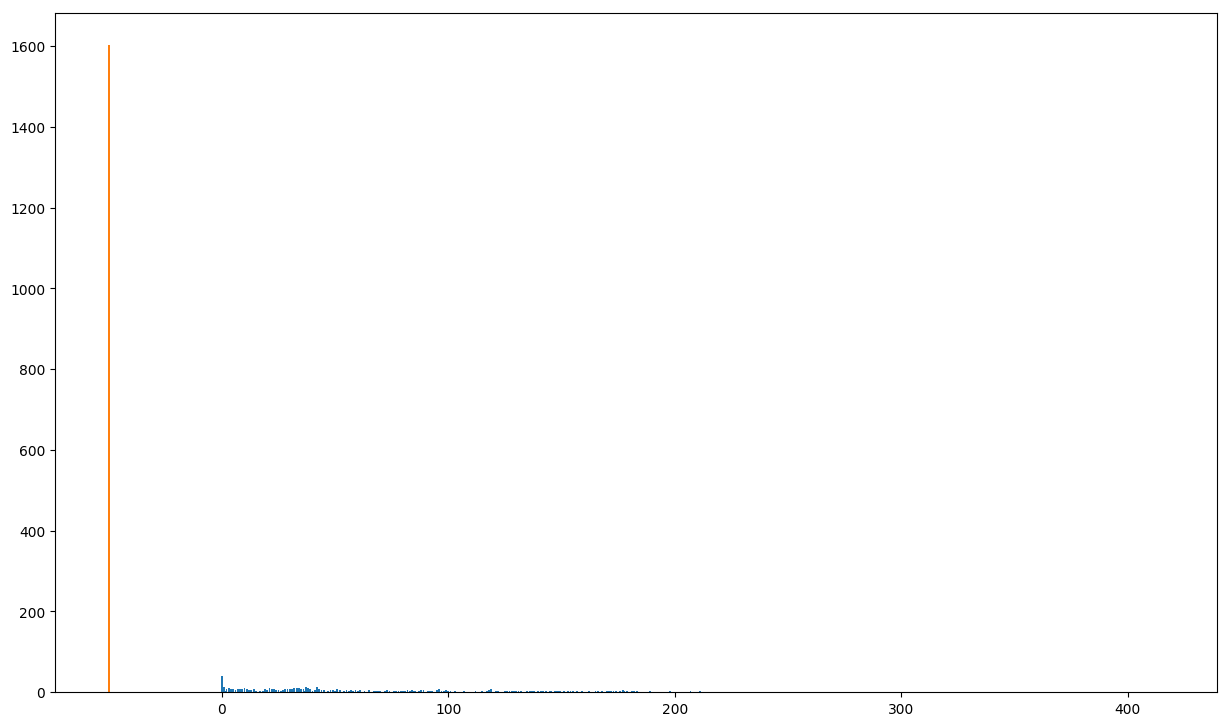

In [40]:
distribution_attribute = table['timezoneJS']

figure = plt.figure(figsize=(15,9), dpi=100)   
graph = figure.add_subplot(1,1,1)#1x1 grid

freq = pd.value_counts(distribution_attribute, dropna=False)
bins = freq.index
x=graph.bar(bins, freq.values) #gives the graph without NaN

graphmissing = figure.add_subplot(1,1,1)
y = graphmissing.bar([-50], freq[np.NaN]) #gives a bar for the number of missing values at x=0

figure.show()

In [ ]:
hist, bin_edges = np.histogram(pd.value_counts(distribution_attribute, dropna=False), bins=50, normed=True)

plt.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], color='red', alpha=0.5)